# Topic Modeling

il topic modeling rappresenta un bel punto su cui partire per analizzare la fattorizzazione delle matrici.
Partiamo con la matrice termine documento.

![term matrix](images\document_term.png)

Possiamo scomporre questa matrice in una matrice alta e sottile che va a moltiplicarsi in una larga e corta (con una matrice diagonale in mezzo)

Si noti che questa rappresentazione non tiene conto dell'ordine della parole o della struttura della frase. E' un esempio dell'approccio bag of words.


## Motivazione

Consideriamo il caso estremo - ricostruire la matrice usando un prodotto esterno di due vettori.
Chiaramente, nella maggioranza dei casi non saremo in grafo di ricostruire la matrice esattamente.

Ma se avessimo un vettore con la frequenza relativa di ogni parola del vocabolario sul conteggio totale delle parole e uno con il numero medio di parole per documento, allora quel prodotto esterno sarebbe il più vicino possibile.

Ora consideriamo di aumentare questa matrice a due colonne e due righe. La decomposizione ottimale sarebbe quella di raggruppare  i documenti in due gruppi, uno dei quali ha una distribuzione il più possibile differente di parole ma il più simile possibile tra i documenti del cluster.
Chiameremo questi due gruppi "topics". Quello che vogliamo è raggruppare le parole in due gruppi, sulla base di quelli che compaiono frequentementi su quei argomenti. 

Prendiamo un insieme di documenti di differenti categorie e troviamo gli argomenti (che consistono in un gruppo di parole) per essi.
Conoscere le categorie attiali ci aiuta a valutare se gli argomenti che abbiamo trovato hanno senso.
Proveremo ad usare due sistemi di fattorizzazione:

* SVD singular value decomposition
* NMF non negative matrix factorization



In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
np.set_printoptions(suppress=True)

## Impostazione dei dati

Scikit learn ha un sacco di dataset con cui iniziare a lavorare, partiamo con un piccolo sottoinsieme di argomenti

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [4]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

Controlliamo degli esempio di argomenti:

In [5]:
print("\n".join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

In [6]:
newsgroups_train.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [7]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1], dtype=int64)

In [8]:
num_topics, num_top_words = 6, 8

Ora grazie a scikit learn abbiamo un metodo per estrarre tutte le parole e contarle.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [10]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26576)

In [11]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [12]:
vocab = np.array(vectorizer.get_feature_names())

In [13]:
vocab[7000:7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel',
       'counselees', 'counselor', 'count'], dtype='<U80')

## Decomposizione a valori singoli

Ci aspettiamo che una parola che appare più frequentemente in un argomento appaia meno frequentementemente negli altri.
Altrimenti quella parola non sarebbe una buona scelta per separare due argomenti.
Pertanto ci aspettiamo che gli argomenti siano ortogonali
L'algoritmo SVD fattorizza una matrice in una matrice con colonne ortogonali e una con righe ortogonali e una matrice diagonale che contiene le relative importanze di ogni fattore.

![svd](images\svd_fb.png)

SVD è una decomposizione esatta, visto che le matrici che crea sono grandi abbastanza da ricreare la matrice originale.
SVD è estremamente usata nell'algebra lineare, specificamente nel data science compreso:

* analisi semantica
* filtri collaborativi
* compressione dei dati
* analisi delle componenti principali



In [14]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

Wall time: 1min 35s


In [15]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


Verifichiamo che la decomposizione è corretta: 

In [16]:
ricostruito = U @ np.diag(s) @ Vh
scarto = np.max(np.abs(ricostruito - vectors))
print(f"{scarto:.5f}")

0.00000


In [17]:
np.allclose(ricostruito,vectors)

True

Verifica che U e Vh sono ortonormali

In [18]:
np.allclose(U @ U.T,np.eye(2034))

True

In [19]:
np.allclose((Vh @ Vh.T),np.eye(2034))

True

## Topic

Analizziamo ora gli argomenti utilizzando la matrice s

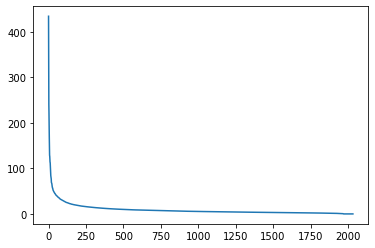

In [20]:
plt.plot(s);

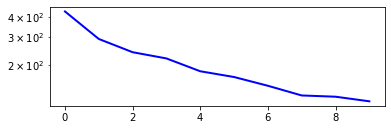

In [21]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
line, = ax.plot(s[:10], color='blue', lw=2)
ax.set_yscale('log')

Analizziamo ora le parole divise per argomenti 

In [22]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [23]:
show_topics(Vh[:8])

['critus ditto propagandist surname galacticentric kindergarten surreal imaginative',
 'edu graphics data space pub mail 128 3d',
 'space jesus launch god people satellite matthew atheists',
 'space launch satellite commercial nasa satellites market year',
 'jpeg graphics space pub edu ray mail send',
 'jesus matthew prophecy messiah psalm isaiah david said',
 'launch commercial satellite market image services satellites launches',
 'data available nasa ftp grass anonymous contact gov']

Otteniamo dei gruppi di argomenti (topic) che corrispondono a quanto richiesto. Questo considerando il fatto che si tratta di un algoritmo non supervisionato. 

Torneremo su SVD più nel dettaglio più avanti. Per ora l'importante è ricordarci che abbiamo uno strumento che ci permette di estrarre una fattorizzazione matriciale in colonne ortogonali e righe ortogonali.

## Non-negative Matrix Factorization (NMF)


![face pca](images\face_pca.png)


un approccio più comprensibile

![face nmf](images\face_outputs.png)


L'idea è che pittosto che avere fattori ortogonali potremmo avere il vincolo che essi siano non negativi.
NMF rappresenta una fattorizzazione di un dataset non negativo $V$ in:

$$V = WH$$

$W$ e $H$ sono matrici non negative. Spesso i fattori positivi sono più facili da interpretare. Questa è la ragione del perchè NMF è popolare.

![face nmf](images\face_nmf.png)


Nonnegative matrix factorization (NMF) è una fattorizzazione non esatta, NMF è un problema NP-Difficile e la soluzione non è univoca. Ci sono molte variazioni su di essto, create aggiungendo differenti vincoli.

## NMF con sklearn

utilizziamo l'implementazione di [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)

In [24]:
m,n=vectors.shape
d=8  # num topics

In [25]:
clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [26]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray send ftp',
 'launch space satellite commercial market satellites year data',
 'jesus matthew prophecy people said messiah david isaiah',
 'image data available software processing ftp edu analysis',
 'god atheists atheism religious believe people religion does',
 'space nasa shuttle available information center data list',
 'probe lunar mars moon surface probes orbit earth']

## TF-IDF

Term Frequency-Inverse Document Frequency (TF-IDF) è un sistema per normalizzare i termini 

* TF = (numero di occorrenze di t nel documento) / (numero di parole nel documento)
* IDF = log(numero di documenti / numero di documenti che contengono la parola t)



In [27]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [28]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [29]:
show_topics(H1)

['don people think just like say know religion',
 'files file image format cview tiff gif use',
 'space nasa launch shuttle orbit lunar moon station',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe atheism christian belief does',
 'objective morality values moral subjective science absolute claim',
 'graphics comp software group 3d aspects amiga just',
 'thanks know looking advance does mail help hi']

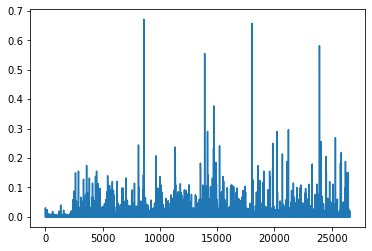

In [30]:
plt.plot(clf.components_[0])

In [31]:
clf.reconstruction_err_

43.53336436449125

In [32]:
W1[0]

array([0.00213864, 0.14095082, 0.        , 0.00582631, 0.00833493,
       0.0036465 , 0.        , 0.01673103])

## Truncated SVD

Abbiamo salvato un sacco di tempo quando abbiamo calcolato la fattorizzazione NMF con un sottoinsieme di colonne a cui siamo interessati. Perchè non usare questa ottimizzazione anche con SVD?
Si chiama truncated SVD.

Carenze dei metodi classici di decomposizione:

* Le matrici sono sorprendentemente grandi
* I dati sono spesso mancanti o inaccurati. Perchè spendere un sacco di risorse computazionali quando sono imprecisi
* Il trasferimento dei dati ora gica un ruolo importante. Le tecniche che richiedono poche passate sui dati sono sostanzialmente più velocu anche se richiedono più flops (flops = floating point operations).
* E' importante prendere quanto più possibile i vantaggi dalle GPU.

Vantaggi degli algoritmi randomizzati:
* intrinsicamente stabili
* le performances sono garantite non dipendono da sottili proprietà spettrali
* possibilità di parallelizazione


In [33]:
%time u, s, v = decomposition.randomized_svd(vectors, 5)

Wall time: 7.4 s


In [34]:
u.shape, s.shape, v.shape

((2034, 5), (5,), (5, 26576))

In [35]:
show_topics(v)

['jpeg image edu file graphics images gif data',
 'jpeg gif file color quality image jfif format',
 'space jesus launch god people satellite matthew atheists',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display']